# Support Vector Machines

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()
from scipy import stats

#import warnings
#warnings.filterwarnings("ignore")

### Motivating Support Vector Machines

As part of our disussion of Bayesian classification, we learned a simple model describing the distribution of each underlying class, and used these generative models to probabilistically determine labels for new points.
That was an example of *generative classification*; here we will consider instead *discriminative classification*: rather than modeling each class, we simply find a line or curve (in two dimensions) or manifold (in multiple dimensions) that divides the classes from each other.

As an example of this, consider the simple case of a classification task, in which the two classes of points are well separated:

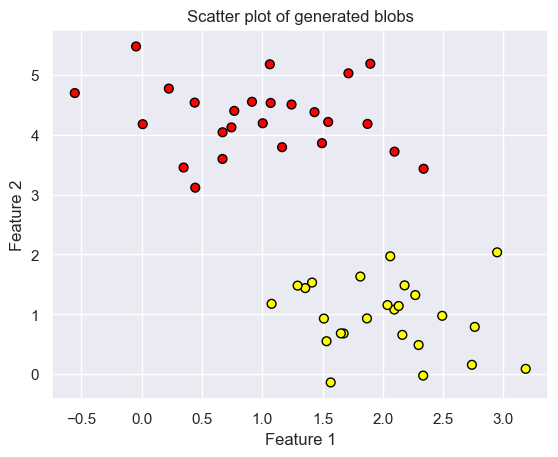

In [2]:
from sklearn.datasets import make_blobs

# Generate synthetic data with 50 samples, 2 centers, and a specific standard deviation
X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=0.60)

# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter plot of generated blobs')
plt.show()

A linear discriminative classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand. But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!



We can draw them as follows:

(-1.0, 3.5)

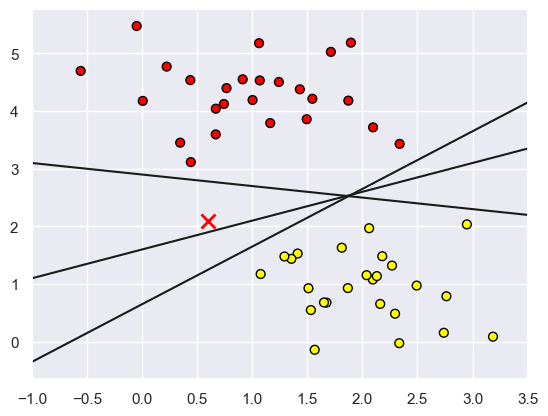

In [3]:
# Generate a range of x values from -1 to 3.5 for plotting lines
xfit = np.linspace(-1, 3.5)

# Create a scatter plot of the data points with a black border
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')

# Plot a red 'x' marker at the coordinate (0.6, 2.1), with a thicker border and larger size
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

# Plot three lines with different slopes (m) and intercepts (b) in black
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

# Set the x-axis limits from -1 to 3.5
plt.xlim(-1, 3.5)

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples.
Depending on which you choose, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label!
Evidently our simple intuition of "drawing a line between classes" is not enough, and we need to think a bit deeper.

## Support Vector Machines: Maximizing the *Margin*

Support vector machines offer one way to improve on this.
The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point.
Here is an example of how this might look:

(-1.0, 3.5)

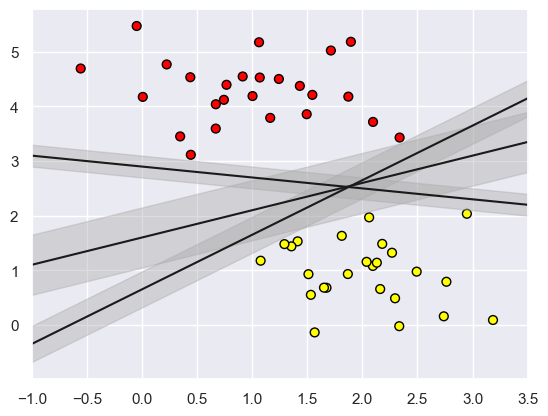

In [4]:
# Generate a range of x values from -1 to 3.5 for plotting lines
xfit = np.linspace(-1, 3.5)

# Create a scatter plot of the data points with colors according to y and a size of 40
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')

# Loop through each set of parameters (slope, intercept, and deviation)
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    # Calculate the y values for the line based on the slope and intercept
    yfit = m * xfit + b
    # Plot the line with the given slope and intercept in black
    plt.plot(xfit, yfit, '-k')
    # Fill the area between two lines to represent the uncertainty or error region
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

# Set the x-axis limits from -1 to 3.5
plt.xlim(-1, 3.5)

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model.
Support vector machines are an example of such a *maximum margin* estimator.

### Fitting a Support Vector Machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.
For the time being, we will use a linear kernel and set the ``C`` parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [5]:
from sklearn.svm import SVC

# Create a Support Vector Classification (SVC) model 
model = SVC(kernel='linear', C=1E10)  # with a linear kernel and a very high regularization parameter (C=1E10)

# Fit the SVC model to the data X and the target labels y
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [6]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    
    """Plot the decision function for a 2D Support Vector Classification (SVC) model."""
    
    # Use the current Axes object if none is provided
    if ax is None:
        ax = plt.gca()
        
    # Get the limits of the x and y axes from the Axes object
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Create a grid of points to evaluate the model's decision function
    x = np.linspace(xlim[0], xlim[1], 30)             # Generate 30 points between x-axis limits
    y = np.linspace(ylim[0], ylim[1], 30)             # Generate 30 points between y-axis limits
    Y, X = np.meshgrid(y, x)                          # Create a mesh grid for X and Y
    xy = np.vstack([X.ravel(), Y.ravel()]).T          # Flatten the grid and stack into an array
    P = model.decision_function(xy).reshape(X.shape)  # Compute decision function values and reshape

    # Plot the decision boundary and margins
    ax.contour(X, Y, P, colors='k',                  # Draw contour lines
               levels=[-1, 0, 1], alpha=0.5,         # Levels of contour lines: -1, 0, and 1
               linestyles=['--', '-', '--'])         # Line styles for the contours

    # Plot support vectors if required
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],    # X coordinates of support vectors
                   model.support_vectors_[:, 1],    # Y coordinates of support vectors
                   s=300,                           # Size of support vector markers
                   linewidth=1,                     # Line width of support vector markers
                   facecolors='none')               # No fill color for support vector markers

    # Restore the original limits of the x and y axes
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

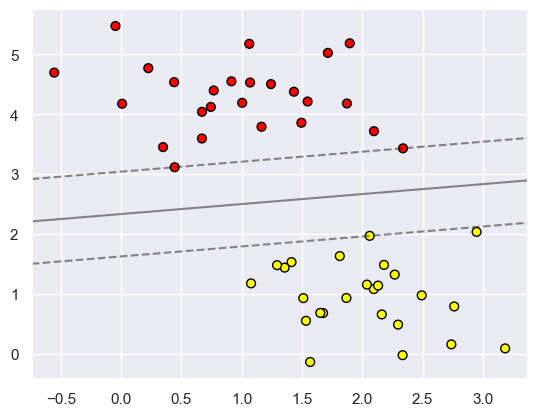

In [7]:
# Create a scatter plot of the data points
plt.scatter(X[:, 0], X[:, 1],        # X and Y coordinates of the data points
            c=y,                     # Color the points based on their labels
            s=40,                    # Size of the data point markers
            cmap='autumn',           # Colormap for coloring the points
            edgecolor='black')       # Border color for the data point markers

# Plot the decision function for the SVC model
plot_svc_decision_function(model)     # Call the function to plot decision boundaries and margins

This is the dividing line that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin.
These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name.
In Scikit-Learn, the identity of these points are stored in the ``support_vectors_`` attribute of the classifier:

In [8]:
# Access the support vectors of the trained SVC model
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

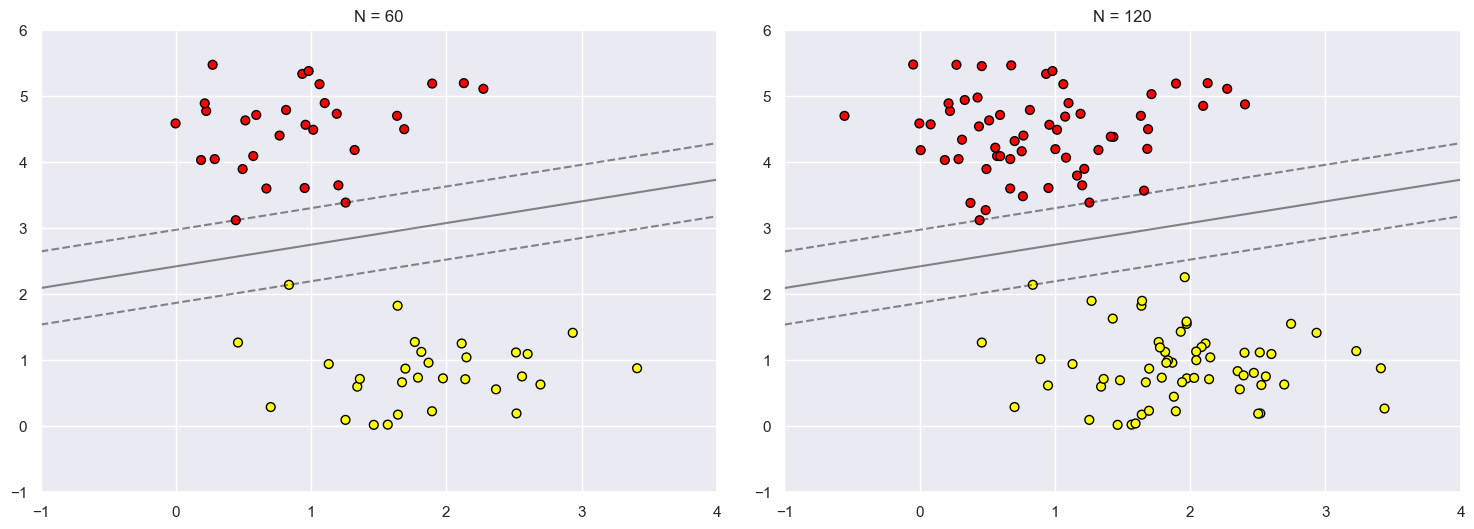

In [9]:
def plot_svm(N=10, ax=None):
    
    """Plot SVM decision boundary and support vectors for a subset of data."""
    
    # Generate synthetic data with 2 centers (classes)
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    
    # Select the first N samples for the plot
    X = X[:N]
    y = y[:N]
    
    # Initialize and fit the Support Vector Machine model with a linear kernel
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    # Use the provided axis or get the current axis if none is provided
    ax = ax or plt.gca()
    
    # Scatter plot the data points with color based on their class
    ax.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')
    
    # Set the limits for the x and y axes
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    
    # Plot the SVM decision boundary and margins
    plot_svc_decision_function(model, ax)

# Create a figure with 1 row and 2 columns of subplots, with a specific size
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Adjust the layout of the subplots
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# Plot SVM decision boundaries for different numbers of data points
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)  # Plot SVM for the current number of points
    axi.set_title('N = {0}'.format(N))  # Set the title for the subplot

In the left panel, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.
Before, we projected our data into higher-dimensional space defined by polynomials and Gaussian basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea.
To motivate the need for kernels, let's look at some data that is not linearly separable:

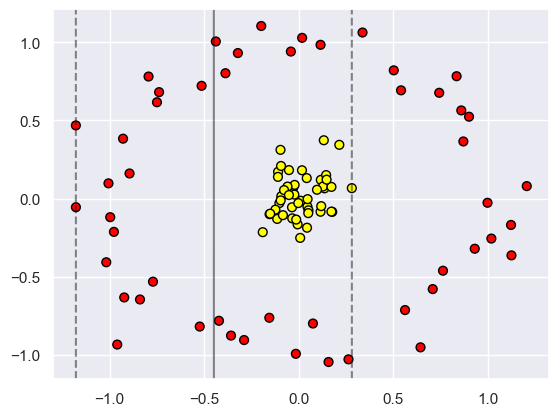

In [10]:
from sklearn.datasets import make_circles  # Updated import

# Generate synthetic data in the shape of concentric circles
X, y = make_circles(100, factor=.1, noise=.1)

# Fit a linear SVM model to the circular data
clf = SVC(kernel='linear').fit(X, y)

# Plot the data points with color based on their class
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')

# Plot the decision function and margins
plot_svc_decision_function(clf, plot_support=False)

plt.show()

It is clear that no linear discrimination will *ever* be able to separate this data.
But we can draw a lesson from the basis function regressions, and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.
For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump:

In [11]:
# Compute the exponentiated negative squared sum of each row in the array X.
r = np.exp(-(X ** 2).sum(1))

In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results.
This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large.
However, because of a neat little procedure known as the [*kernel trick*](https://en.wikipedia.org/wiki/Kernel_trick), a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection!
This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the ``kernel`` model hyperparameter:

In [12]:
# Initialize the Support Vector Classifier with a radial basis function (RBF) kernel
# and a very high regularization parameter (C=1E6).
# The RBF kernel allows the classifier to handle non-linear relationships.
clf = SVC(kernel='rbf', C=1E6)

# Fit the SVM model to the data (X) and labels (y).
# This trains the model to find the optimal decision boundary for the given data.
clf.fit(X, y)

SVC(C=1000000.0)

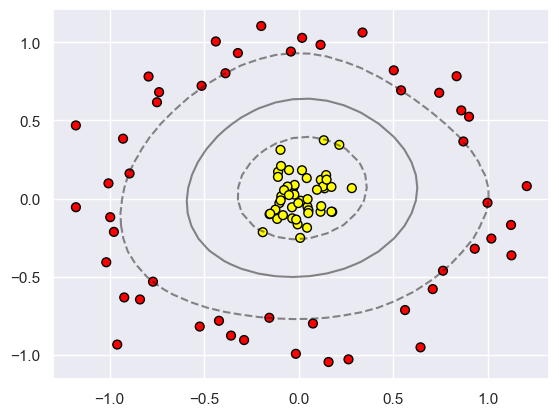

In [13]:
# Scatter plot of the data points, with colors representing different classes (y).
# Each point is plotted with a black border.
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')

# Plot the decision function and margins of the SVM classifier.
# This function visualizes the decision boundary and the regions of different class predictions.
plot_svc_decision_function(clf)

# Scatter plot of the support vectors from the trained SVM classifier.
# Support vectors are highlighted with a large size (s=300) and a black border (lw=1).
# The facecolor is set to 'none' to make them more distinct.
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Tuning the SVM: Softening Margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists.
But what if your data has some amount of overlap?
For example, you may have data like this:

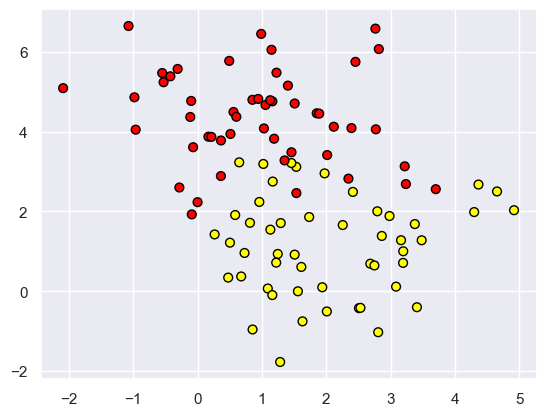

In [14]:
# Generate a synthetic dataset with 100 samples, divided into 2 centers (clusters).
# The data points are created with a standard deviation of 1.2 for each cluster.
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)

# Create a scatter plot of the generated data points.
# The points are colored according to their class labels (y), with the colormap 'autumn'.
# Each point is plotted with a size of 40.
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit.
The hardness of the margin is controlled by a tuning parameter, most often known as $C$.
For very large $C$, the margin is hard, and points cannot lie in it.
For smaller $C$, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

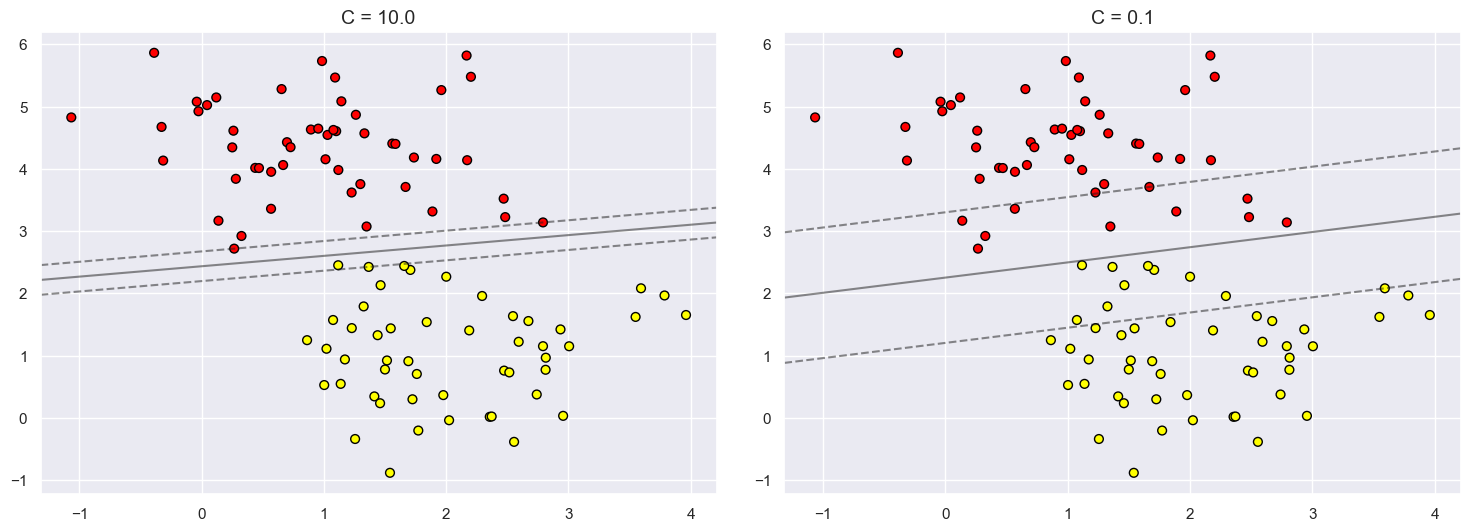

In [15]:
# Generate a synthetic dataset with 100 samples and 2 centers (clusters).
# The clusters have a standard deviation of 0.8, making them closer together.
X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)

# Create a figure with two subplots arranged in a single row.
# Set the overall figure size and adjust spacing between the subplots.
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# Iterate over the two subplots and the corresponding values of the regularization parameter C.
for axi, C in zip(ax, [10.0, 0.1]):
    # Create and fit a linear Support Vector Classifier (SVC) model with the current value of C.
    model = SVC(kernel='linear', C=C).fit(X, y)
    
    # Scatter plot of the data points, colored by their class labels.
    # Points are plotted with a size of 40 and colored using the 'autumn' colormap.
    # Black edges are added around each point for better visibility.
    axi.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn', edgecolor='black')
    
    # Plot the decision function of the fitted SVC model.
    # This function highlights the decision boundary and margins.
    plot_svc_decision_function(model, axi)
    
    # Scatter plot of the support vectors of the SVC model.
    # Support vectors are plotted with a larger size (300) and no fill color.
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none')
    
    # Set the title of the subplot to indicate the value of C used for this plot.
    axi.set_title('C = {0:.1f}'.format(C), size=14)


The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

# Example: Face Recognition

As an example of Support Vector Machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [16]:
from sklearn.datasets import fetch_lfw_people

# Fetch the Labeled Faces in the Wild dataset with at least 60 images per person.
# This dataset contains labeled face images of various individuals.
faces = fetch_lfw_people(min_faces_per_person=60)

# Print the names of the individuals in the dataset.
# 'faces.target_names' is a list of the names corresponding to the target labels.
print(faces.target_names)

# Print the shape of the images array in the dataset.
# 'faces.images.shape' gives the dimensions of the array where each image is represented.
# The shape is (n_samples, height, width), where n_samples is the number of images,
# and height and width represent the dimensions of each image.
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

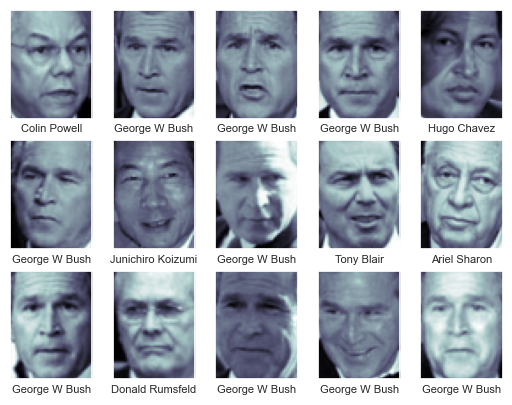

In [17]:
# Create a 3x5 grid of subplots using Matplotlib's 'subplots' function.
# 'fig' is the figure object, and 'ax' is an array of Axes objects.
fig, ax = plt.subplots(3, 5)

# Adjust spacing between subplots
#fig.subplots_adjust(wspace=0.5, hspace=0.5)  # Increase space between subplots

# Loop over each subplot and the corresponding index using 'enumerate' on the flattened array of Axes.
for i, axi in enumerate(ax.flat):
    # Display an image in the current subplot using 'imshow'.
    # 'faces.images[i]' is the image data, and 'cmap' specifies the colormap (in this case, 'bone' is used for a grayscale effect).
    axi.imshow(faces.images[i], cmap='bone')
    
    # Remove x and y axis ticks from the subplot.
    # 'set(xticks=[], yticks=[])' removes the tick marks and labels from both axes.
    axi.set(xticks=[], yticks=[])
    
    # Label each subplot with the name of the person corresponding to the image.
    # 'xlabel' sets the label on the x-axis using the target name associated with the image.
    # 'faces.target_names[faces.target[i]]' retrieves the name of the person from 'faces.target_names'.
    axi.set_xlabel(faces.target_names[faces.target[i]], fontsize=8)

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [18]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

# Initialize PCA (Principal Component Analysis) for dimensionality reduction
# n_components=150: Reduce the data to 150 principal components
# whiten=True: Normalize the components to have unit variance
# random_state=42: Ensure reproducibility of the results
pca = PCA(n_components=150, whiten=True, random_state=42)

# Initialize an SVC (Support Vector Classification) model
# kernel='rbf': Use the Radial Basis Function kernel for non-linear classification
# class_weight='balanced': Adjust weights inversely proportional to class frequencies in the input data
svc = SVC(kernel='rbf', class_weight='balanced')

# Create a pipeline that first applies PCA, then fits the SVC model
# make_pipeline: Combines PCA and SVC into a single workflow
model = make_pipeline(pca, svc)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [19]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data,       # faces.data: Feature data (images)
                                                faces.target,     # faces.target: Target labels (names)
                                                random_state=42)  # random_state=42: Seed for reproducibility

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [20]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'svc__C': [1, 5, 10, 50],          # List of regularization parameters to test
    'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]  # List of gamma values to test
}

# Create a GridSearchCV object with the model and parameter grid
grid = GridSearchCV(model, param_grid)

# Fit the GridSearchCV object to the training data and measure execution time
%time grid.fit(Xtrain, ytrain)

# Print the best parameters found during the grid search
print(grid.best_params_)

CPU times: total: 27 s
Wall time: 18.3 s
{'svc__C': 5, 'svc__gamma': 0.001}


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [21]:
# Retrieve the best estimator from the grid search results
model = grid.best_estimator_

# Predict the labels for the test set using the best model
yfit = model.predict(Xtest)

Let's take a look at a few of the test images along with their predicted values:

Text(0.5, 0.98, 'Predicted Names; Incorrect Labels in Red')

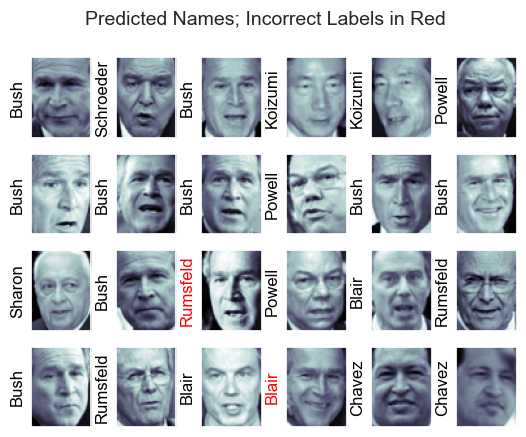

In [22]:
# Create a 4x6 grid of subplots
fig, ax = plt.subplots(4, 6)

# Iterate over each subplot and corresponding test image
for i, axi in enumerate(ax.flat):
    # Reshape and display the image for the current subplot
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    
    # Remove x and y ticks for cleaner display
    axi.set(xticks=[], yticks=[])
    
    # Set the y-axis label to the predicted name
    # Color the label black if prediction matches the true label, else red
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red', fontsize=12)

# Set the title for the entire figure
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14)

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s face in the bottom row was mislabeled as Blair). We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [23]:
from sklearn.metrics import classification_report

# Print a classification report to evaluate model performance
print(classification_report(ytest,   # True labels for the test set
                            yfit,    # Predicted labels for the test set
                            target_names=faces.target_names))    # List of target names for the labels

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



We might also display the confusion matrix between these classes:

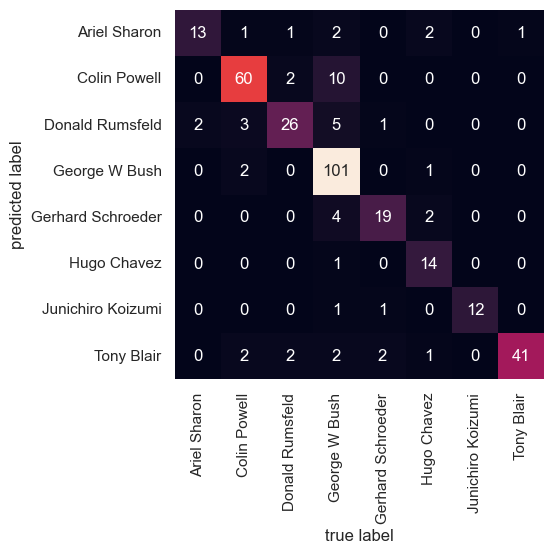

In [24]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
mat = confusion_matrix(ytest, yfit)  # ytest: True labels, yfit: Predicted labels

# Plot the confusion matrix as a heatmap
sns.heatmap(mat.T,               # Transpose the matrix for correct orientation
            square=True,         # Ensure the heatmap is square
            annot=True,          # Annotate cells with the numeric values
            fmt='d',             # Format the annotation as integers
            cbar=False,          # Do not display the color bar
            xticklabels=faces.target_names,  # Label the x-axis with target names
            yticklabels=faces.target_names)  # Label the y-axis with target names

plt.xlabel('true label')       # Label for the x-axis
plt.ylabel('predicted label')  # Label for the y-axis
plt.show()

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

## Support Vector Machine Summary

We have seen here a brief intuitive introduction to the principals behind support vector machines.
These methods are a powerful classification method for a number of reasons:

- Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
- Once the model is trained, the prediction phase is very fast.
- Because they are affected only by points near the margin, they work well with high-dimensional data—even data with more dimensions than samples, which is a challenging regime for other algorithms.
- Their integration with kernel methods makes them very versatile, able to adapt to many types of data.

However, SVMs have several disadvantages as well:

- The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
- The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
- The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the ``probability`` parameter of ``SVC``), but this extra estimation is costly.

With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs.
Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.